In [70]:
import numpy as np
import matplotlib.pyplot as plt

import string
import random
import re
import requests
import os
import textwrap

In [135]:
# create substituion chyper
letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

true_mapping = {}

random.shuffle(letters2)

for k, v in zip(letters1, letters2):
    true_mapping[k] = v

In [147]:
M = np.ones((26, 26))

# initial state
pi = np.zeros(26)

def update_transition(ch1, ch2):
    i = ord(ch1) - 97
    j = ord(ch2) - 97
    M[i, j] += 1
    
def update_pi(ch):
    i = ord(ch) - 97
    pi[i] += 1

In [159]:
def get_word_prob(word):
    i = ord(word[0]) - 97
    logp = np.log(pi[i])
    
    for ch in word[1:]:
        j = ord(ch) - 97
        logp += np.log(M[i, j])
        i = j
        
    return logp

def get_sequence_prob(words):
    if type(words) == str:
        words = words.split()
        
    logp = 0
    for word in words:
        logp += get_word_prob(word)
    return logp

In [259]:
# regex for replacing non-alpha characters
regex = re.compile('[^a-zA-Z]')

# load in words
for line in open('../data/moby_dick.txt'):
    line = line.rstrip()
    
    if line:
        line = regex.sub(' ', line) # replace all non-alpha chars with space
        
        # split tokens in the line and lowercase
        tokens = line.lower().split()
        
        for token in tokens:
            # update the model
            ch0 = token[0]
            update_pi(ch0)
            
            for ch1 in token[1:]:
                update_transition(ch0, ch1)
                ch0 = ch1
                
# normalize the probs
pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True)

In [260]:
original_message = '''In many of the more relaxed civilizations of the Outer Eastern Rim
of the Galaxy, the Hitch Hiker's Guide has already supplanted the great Encyclopedia Galactica as the standard repository of all knowledge and wisdom, for though it has many
omissions and contains much that is apocryphal, or at least widly inaccurate, it scores over
the older, more pedestrian work in two important respects.
'''

In [261]:
def encode_message(msg):
  # downcase
  msg = msg.lower()

  # replace non-alpha characters
  msg = regex.sub(' ', msg)

  # make the encoded message
  coded_msg = []
  for ch in msg:
    coded_ch = ch # could just be a space
    if ch in true_mapping:
      coded_ch = true_mapping[ch]
    coded_msg.append(coded_ch)

  return ''.join(coded_msg)
    
encoded_message = encode_message(original_message)

In [262]:
print(encoded_message)

pk avkn ch dow acsw swmvgwj qpypmpuvdpckb ch dow czdws wvbdwsk spa ch dow rvmvgn  dow opdqo opfws b rzpjw ovb vmswvjn bzllmvkdwj dow rswvd wkqnqmclwjpv rvmvqdpqv vb dow bdvkjvsj swlcbpdcsn ch vmm fkcxmwjrw vkj xpbjca  hcs doczro pd ovb avkn capbbpckb vkj qckdvpkb azqo dovd pb vlcqsnlovm  cs vd mwvbd xpjmn pkvqqzsvdw  pd bqcswb cyws dow cmjws  acsw lwjwbdspvk xcsf pk dxc palcsdvkd swblwqdb  


In [263]:
def decode_message(msg, word_map):
  decoded_msg = []
  for ch in msg:
    decoded_ch = ch # could just be a space
    if ch in word_map:
      decoded_ch = word_map[ch]
    decoded_msg.append(decoded_ch)

  return ''.join(decoded_msg)

In [264]:
# run an evolutionary algorithm to decode the message
dna_pool = []
for _ in range(20):
    dna = list(string.ascii_lowercase)
    random.shuffle(dna)
    dna_pool.append(dna)

In [265]:
def evolve_offspring(dna_pool, n_children):
  # make n_children per offspring
  offspring = []

  for dna in dna_pool:
    for _ in range(n_children):
      copy = dna.copy()
      j = np.random.randint(len(copy))
      k = np.random.randint(len(copy))

      # switch
      tmp = copy[j]
      copy[j] = copy[k]
      copy[k] = tmp
      offspring.append(copy)

  return offspring + dna_pool

In [266]:
num_iters = 1000
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')
for i in range(num_iters):
  if i > 0:
    # get offspring from the current dna pool
    dna_pool = evolve_offspring(dna_pool, 3)

  # calculate score for each dna
  dna2score = {}
  for dna in dna_pool:
    # populate map
    current_map = {}
    for k, v in zip(letters1, dna):
      current_map[k] = v

    decoded_message = decode_message(encoded_message, current_map)
    score = get_sequence_prob(decoded_message)

    # store it
    # needs to be a string to be a dict key
    dna2score[''.join(dna)] = score

    # record the best so far
    if score > best_score:
      best_dna = dna
      best_map = current_map
      best_score = score

  # average score for this generation
  scores[i] = np.mean(list(dna2score.values()))

  # keep the best 5 dna
  # also turn them back into list of single chars
  sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True)
  dna_pool = [list(k) for k, v in sorted_dna[:5]]

  if i % 200 == 0:
    print("iter:", i, "score:", scores[i], "best so far:", best_score)

iter: 0 score: -9693.242518569112 best so far: -5925.015941077955
iter: 200 score: -1264.8218681651829 best so far: -874.6005000653769
iter: 400 score: -1211.2275015012196 best so far: -792.0199183385083
iter: 600 score: -1609.0227731362177 best so far: -792.0199183385083
iter: 800 score: -1156.5724980526788 best so far: -792.0199183385083


In [267]:
decoded_message = decode_message(encoded_message, best_map)

print("LL of decoded message:", get_sequence_prob(decoded_message))
print("LL of true message:", get_sequence_prob(regex.sub(' ', original_message.lower())))

#which letters are wrong?
for true, v in true_mapping.items():
    pred = best_map[v]
    if true != pred:
        print("true: %s, pred: %s" % (true, pred))

LL of decoded message: -792.0199183385083
LL of true message: -803.5930599788461
true: b, pred: q
true: j, pred: x
true: q, pred: j
true: x, pred: b


In [268]:
print("Decoded message:\n", textwrap.fill(decoded_message))
print("\nTrue message:\n", original_message)

Decoded message:
 in many of the more relabed civilizations of the outer eastern rim of
the galaby  the hitch hiker s guide has already supplanted the great
encyclopedia galactica as the standard repository of all knowledge and
wisdom  for though it has many omissions and contains much that is
apocryphal  or at least widly inaccurate  it scores over the older
more pedestrian work in two important respects

True message:
 In many of the more relaxed civilizations of the Outer Eastern Rim
of the Galaxy, the Hitch Hiker's Guide has already supplanted the great Encyclopedia Galactica as the standard repository of all knowledge and wisdom, for though it has many
omissions and contains much that is apocryphal, or at least widly inaccurate, it scores over
the older, more pedestrian work in two important respects.



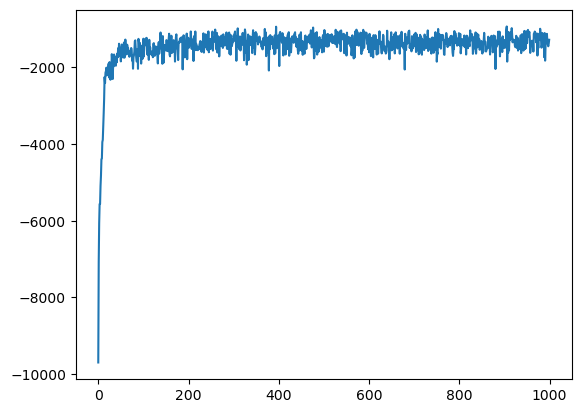

In [269]:
plt.plot(scores)